In [1]:
import tensorflow as tf
# import gymnasium as gym
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import gym

print(tf.__version__)
print(gym.__version__)

2023-07-27 01:10:39.969569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-27 01:10:39.969617: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.7.0
0.18.0


# REINFORCE Agent:

In [2]:
#defining a standard dense NN

def build_model(state_size, action_size, learning_rate = 0.001):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(16, input_dim = state_size, activation = 'relu'))
    model.add(tf.keras.layers.Dense(16))
    model.add(tf.keras.layers.Dense(2, activation = 'relu', kernel_initializer='RandomNormal'))
    model.add(tf.keras.layers.Dense(action_size, activation = 'softmax'))
    return model

In [3]:
#function that gathers episodes of interaction with the environment
def gather_episodes(state_bounds, n_actions, model, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)]


    done = [False for _ in range(n_episodes)]
    states = [e.reset()[0] for e in envs]

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        # Compute policy for all unfinished envs in parallel
        states = tf.convert_to_tensor(normalized_states)
        action_probs = model([states])

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, policy in zip(unfinished_ids, action_probs.numpy()):
            #print(policy)
            action = np.random.choice(n_actions, p=policy)
            states[i], reward, done[i], _= envs[i].step(action)
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)

    return trajectories

In [4]:
def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [5]:
#function that updates the policy using states, actions and returns
@tf.function
def reinforce_update(states, actions, returns, model):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    returns = tf.convert_to_tensor(returns)

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        logits = model(states)
        p_actions = tf.gather_nd(logits, actions)
        log_probs = tf.math.log(p_actions)
        loss = tf.math.reduce_sum(-log_probs * returns) / batch_size
    grads = tape.gradient(loss, model.trainable_variables)
    #for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
    #    optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [6]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = build_model(state_size, action_size, 0.1)
#print(len(model.layers))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
 dense_3 (Dense)             (None, 2)                 6         
                                                                 
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________


2023-07-27 01:10:52.698868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-27 01:10:52.699109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-27 01:10:52.699938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-07-27 01:10:52.700177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-07-27 01:10:52.700773: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [7]:
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
n_actions = 2
gamma = 0.99
batch_size = 16
n_episodes = 2000

optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

In [8]:
#main training loop of the agent
env_name = "CartPole-v1"

# Start training the agent
episode_reward_history = []
for batch in range(n_episodes // batch_size):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, model, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = np.concatenate([ep['states'] for ep in episodes])
    actions = np.concatenate([ep['actions'] for ep in episodes])
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = np.array(returns, dtype=np.float32)

    id_action_pairs = np.array([[i, a] for i, a in enumerate(actions)])

    # Update model parameters.
    reinforce_update(states, id_action_pairs, returns, model)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-10:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break


Finished episode 16 Average rewards:  21.8
Finished episode 32 Average rewards:  24.0
Finished episode 48 Average rewards:  34.3
Finished episode 64 Average rewards:  24.7
Finished episode 80 Average rewards:  32.5
Finished episode 96 Average rewards:  36.2
Finished episode 112 Average rewards:  39.9
Finished episode 128 Average rewards:  40.7
Finished episode 144 Average rewards:  37.5
Finished episode 160 Average rewards:  44.1
Finished episode 176 Average rewards:  46.9
Finished episode 192 Average rewards:  62.1
Finished episode 208 Average rewards:  80.0
Finished episode 224 Average rewards:  45.3
Finished episode 240 Average rewards:  87.7
Finished episode 256 Average rewards:  111.2
Finished episode 272 Average rewards:  96.5
Finished episode 288 Average rewards:  65.2
Finished episode 304 Average rewards:  97.5
Finished episode 320 Average rewards:  84.6
Finished episode 336 Average rewards:  115.3
Finished episode 352 Average rewards:  106.7
Finished episode 368 Average reward

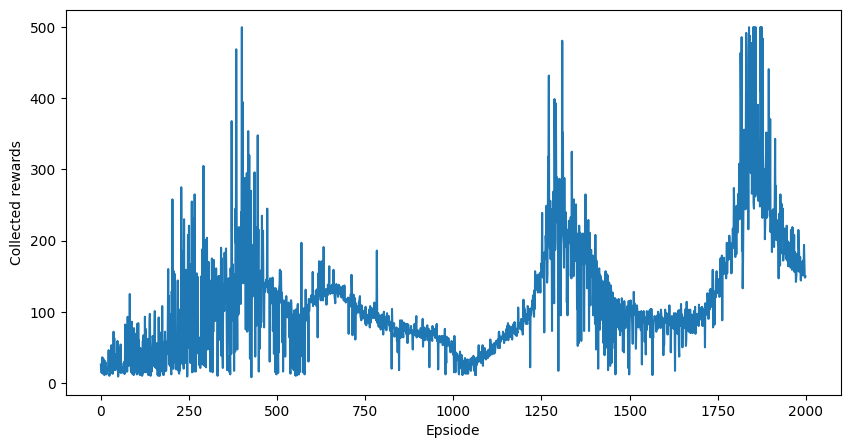

In [9]:
plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

In [13]:
# env = gym.make("CartPole-v1")  # , render_mode="human"
# observation = env.reset()
#
# for _ in range(500):
#     states = tf.convert_to_tensor(observation.reshape(1, -1) / state_bounds)
#     action_probs = np.asarray(model(states)).astype('float64')  # issue with float32
#     action_probs = action_probs/np.sum(action_probs)
#     action = np.random.choice(n_actions, p=action_probs[0])
#     observation, reward, terminated, truncated = env.step(action)
#
#     if terminated or truncated:
#         observation = env.reset()
#
# env.close()

# Deep Q Learning Agent

In [14]:
# Define the Q-network
def build_q_network(state_size, action_size):
    model = keras.Sequential()
    model.add(layers.Dense(24, activation='relu', input_dim=state_size))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(action_size, activation='linear'))
    return model

In [15]:
# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = build_q_network(state_size, action_size)
        self.target_model = build_q_network(state_size, action_size)
        self.replay_memory = deque(maxlen=2000)
        self.model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learning_rate))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.replay_memory.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        if len(self.replay_memory) < batch_size:
            return

        minibatch = np.random.choice(len(self.replay_memory), batch_size, replace=False)
        states = []
        targets = []

        for idx in minibatch:
            state, action, reward, next_state, done = self.replay_memory[idx]
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                q_future = np.max(self.target_model.predict(next_state)[0])
                target[0][action] = reward + self.gamma * q_future

            states.append(state[0])
            targets.append(target[0])

        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

In [16]:
# Create the CartPole environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [17]:
# Create the DQN agent
agent = DQNAgent(state_size, action_size)

/home/geeks_ubuntu/miniconda3/envs/py37_tfq_test_env/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
# Training parameters
n_episodes = 2000
max_timesteps = 500
batch_size = 16
render = False

In [ ]:
# Episode reward history
episode_reward_history = []

# Main training loop
for episode in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    for timestep in range(max_timesteps):
        if render:
            env.render()

        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            agent.update_target_model()
            break

        agent.train(batch_size)

    episode_reward_history.append(total_reward)
    print("Episode:", episode+1, "Total Reward:", total_reward)

Episode: 1 Total Reward: 17.0
Episode: 2 Total Reward: 58.0
Episode: 3 Total Reward: 10.0
Episode: 4 Total Reward: 23.0
Episode: 5 Total Reward: 8.0
Episode: 6 Total Reward: 14.0
Episode: 7 Total Reward: 18.0
Episode: 8 Total Reward: 9.0
Episode: 9 Total Reward: 10.0
Episode: 10 Total Reward: 12.0
Episode: 11 Total Reward: 8.0


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

In [ ]:
# Evaluate the trained agent
total_rewards = []
n_eval_episodes = 10

for _ in range(n_eval_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    episode_reward = 0

    while True:
        env.render()
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        episode_reward += reward
        state = next_state

        if done:
            break

    total_rewards.append(episode_reward)

average_reward = np.mean(total_rewards)
print("Average Reward:", average_reward)

# Close the environment
env.close()

# Actor-Critic Agent

In [ ]:
inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

In [ ]:
num_inputs = 4
num_actions = 2
num_hidden = 128

In [ ]:
# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v1")  # Create the environment
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

In [ ]:
while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break